In [1]:
import os
from utils_finetune import create_model_wrapper
from viz import generate_latent_space
import pandas as pd

In [2]:
main_dir = '/Users/jonaheaton/Desktop/stanford_umap_may29'
data_dir = os.path.join('/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/stanford-hmp2') # data_v1 is only the baseline data

In [3]:
# model_dir = os.path.join(main_dir,'train_model')
# encoder = create_model_wrapper(f'{model_dir}/encoder_info.json',f'{model_dir}/encoder_state.pt')
# head = create_model_wrapper(f'{model_dir}/head_info.json',f'{model_dir}/head_state.pt',is_encoder=False)

model_dir = os.path.join(main_dir,'trainval_model')
encoder = create_model_wrapper(f'{model_dir}/encoder_info.json',f'{model_dir}/encoder_state.pt')
head = create_model_wrapper(f'{model_dir}/head_info.json',f'{model_dir}/head_state.pt',is_encoder=False)

In [4]:
X = pd.read_csv(os.path.join(data_dir, 'finetune_ready_data_matrix.csv'), index_col=0)
y = pd.read_csv(os.path.join(data_dir, 'finetune_ready_metadata.csv'), index_col=0)

In [5]:
X_train_val = pd.read_csv(os.path.join(data_dir, 'data_v3','X_stanford-hmp_trainval.csv'),index_col=0)
y_train_val = pd.read_csv(os.path.join(data_dir, 'data_v3','y_stanford-hmp_trainval.csv'),index_col=0)
X_test = pd.read_csv(os.path.join(data_dir, 'data_v3','X_stanford-hmp_test.csv'),index_col=0)
y_test = pd.read_csv(os.path.join(data_dir, 'data_v3','y_stanford-hmp_test.csv'),index_col=0)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from misc import assign_color_map
import umap

In [7]:

def create_nice_embedding_plot(embedding, hue_col, metadata,is_umap=True,margin_amount=0.1,palette='flare'):
        
    Z_embed = embedding.copy()
    if is_umap:
        Z_embed.columns = ['UMAP1','UMAP2']
    else:
        Z_embed.columns = ['PCA1','PCA2']
    Z_embed[hue_col] = metadata.loc[Z_embed.index, hue_col].values

    Z_count_sum = (~Z_embed[hue_col].isnull()).sum()
    print(f'Number of samples: {Z_count_sum}')
    if Z_embed[hue_col].nunique() > 30:
        # if more than 30 unique values, then assume its continuous
        palette = palette
        Z_counts = None
    else:
        # if fewer than 30 unique values, then assume its categorical
        # palette = get_color_map(Z_embed[hue_col].nunique())
        palette = assign_color_map(Z_embed[hue_col].unique().dropna())
        Z_counts = Z_embed[hue_col].value_counts()
    marker_sz = 250/np.sqrt(Z_count_sum)


    fig = sns.scatterplot(data=Z_embed, x='UMAP1', y='UMAP2', hue=hue_col, palette=palette,s=marker_sz)
    # place the legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # edit the legend to include the number of samples in each cohort
    handles, labels = fig.get_legend_handles_labels()

    # Add the counts to the legend if hue_col is categorical
    if Z_counts is not None:
        # new_labels = [f'{label} ({Z_embed[Z_embed[hue_col]==label].shape[0]})' for label in labels]
        new_labels = []
        for label in labels:
            # new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
            try:
                new_labels.append(f'{label} ({Z_counts.loc[label]})')
            except KeyError:
                new_labels.append(f'{label} ({Z_counts.loc[eval(label)]})')
    else:
        new_labels = labels

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]

    plt.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_col)
    
    # get the limits
    x_min, x_max = Z_embed['UMAP1'].min(), Z_embed['UMAP1'].max()
    y_min, y_max = Z_embed['UMAP2'].min(), Z_embed['UMAP2'].max()
    # add a margin
    plt.xlim(x_min-margin_amount*(x_max-x_min), x_max+margin_amount*(x_max-x_min))
    plt.ylim(y_min-margin_amount*(y_max-y_min), y_max+margin_amount*(y_max-y_min))
    return

In [8]:
def convert_event_to_time(event):
    if event == 'Baseline':
        return 0
    elif event == '2 min':
        return 2
    elif event == '15 min':
        return 15
    elif event == '30 min':
        return 30
    elif event == '1 hour':
        return 60
    elif event == '2 hours':
        return 120
    elif event == '6 hours':
        return 360
    elif event == '24 hours':
        return 1440

In [15]:
hmp_healthy = y[(y['SubStudy'] =='HMP') & (y['Event'] == 'Healthy')].copy()
hmp_healthy['BMI Group'] = pd.cut(hmp_healthy['BMI'], bins=[0, 25, 30,100], labels=['Normal', 'Overweight', 'Obese'])

X_healthy_hmp = X.loc[hmp_healthy.index].copy()
y_healthy_hmp = y.loc[hmp_healthy.index].copy()
Z_healthy = generate_latent_space(X_healthy_hmp,encoder)

In [16]:
hmp_healthy['BMI Group'].value_counts()

BMI Group
Overweight    113
Obese         101
Normal         20
Name: count, dtype: int64

In [11]:
y_train_val.shape

(271, 20)

In [10]:
y_healthy_hmp.shape

(236, 20)

In [8]:
Z_trainval = generate_latent_space(X_train_val, encoder=encoder)
Z_test = generate_latent_space(X_test, encoder=encoder)

In [12]:
df = pd.concat([y_train_val, y_test])
df['BMI Group'] = pd.cut(df['BMI'], bins=[0, 25, 30,100], labels=['Normal', 'Overweight', 'Obese'])
df['Exercise'] = df['Event_Note1'].copy()
df['Exercise Time'] = df['Exercise'].apply(convert_event_to_time)
df['Exercise Time'] = np.log2(df['Exercise Time'] + 1)

In [21]:
hmp_healthy['BMI'].isna().sum()

2

In [19]:
hmp_healthy['BMI Group'].value_counts().sum()

234

In [20]:
df.loc[df['Exercise']=='Baseline','BMI Group'].value_counts().sum()

35

best
15 neigh
0.25
25 randm state


100 
0.0
36

In [50]:
umap_plots_dir = os.path.join('/Users/jonaheaton/Desktop/umap_plots')

# for random_state in [11,25,36,42]:
#     for n_neighbors in [2, 5, 15, 30, 50, 100]:
#         for min_dist in [0.0, 0.1, 0.25, 0.5]:
#             for metric in ['euclidean']:
#                 reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
#                                     metric=metric, random_state=random_state,n_jobs=1)
#                 trainval_embedding = reducer.fit_transform(Z_trainval)
#                 trainval_embedding = pd.DataFrame(trainval_embedding, index=Z_trainval.index)
#                 # test_embedding = reducer.transform(Z_test)
#                 # test_embedding = pd.DataFrame(test_embedding, index=Z_test.index)

#                 create_nice_embedding_plot(trainval_embedding, 'BMI', df, is_umap=True)
#                 plt.title(f'UMAP: n_neighbors={n_neighbors}, min_dist={min_dist}, metric={metric}, random_state={random_state}')
#                 plt.savefig(os.path.join(umap_plots_dir, f'umap_n{n_neighbors}_min_dist{min_dist}_metric{metric}_random_state{random_state}.png'))
#                 plt.close()
                

In [198]:
n_neighbors = 25
min_dist = 0.05
random_state = 25

reducer = umap.UMAP(n_components=2, random_state=random_state, n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean')
trainval_embedding = reducer.fit_transform(Z_trainval)
trainval_embedding = pd.DataFrame(trainval_embedding, index=Z_trainval.index)
test_embedding = reducer.transform(Z_test)
test_embedding = pd.DataFrame(test_embedding, index=Z_test.index)

all_embeddings = pd.concat([trainval_embedding, test_embedding])
all_embeddings.columns = ['UMAP1','UMAP2']

desc_text = f'n_neighbors={n_neighbors}, min_dist={min_dist}, seed={random_state}'
chosen_umap_plots_dir = os.path.join(f'/Users/jonaheaton/Desktop/chosen_umaps/{n_neighbors}_{min_dist}_{random_state}')
os.makedirs(chosen_umap_plots_dir, exist_ok=True)

/Users/jonaheaton/opt/miniconda3/envs/mz_embed_engine/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Number of samples: 269


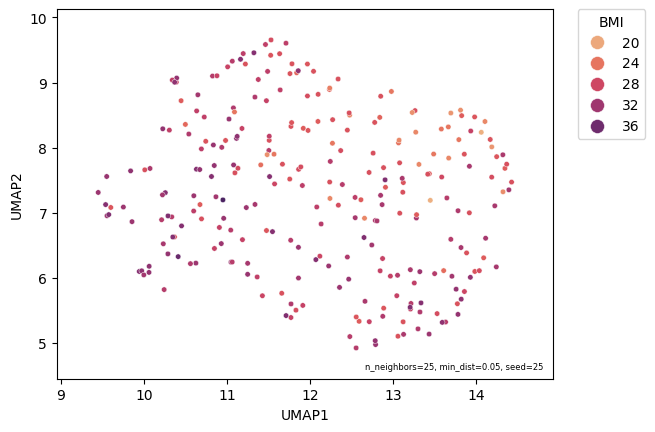

In [199]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, is_umap=True)
# add some text in the corner of the plot
# how to make this text smllar"
plt.text(0.98, 0.02, desc_text, 
    verticalalignment='bottom', 
    horizontalalignment='right', 
    transform=plt.gca().transAxes,
    fontsize=6)

plt.savefig(os.path.join(chosen_umap_plots_dir, 'bmi_embedding.png'), dpi=300, bbox_inches='tight')

Number of samples: 269


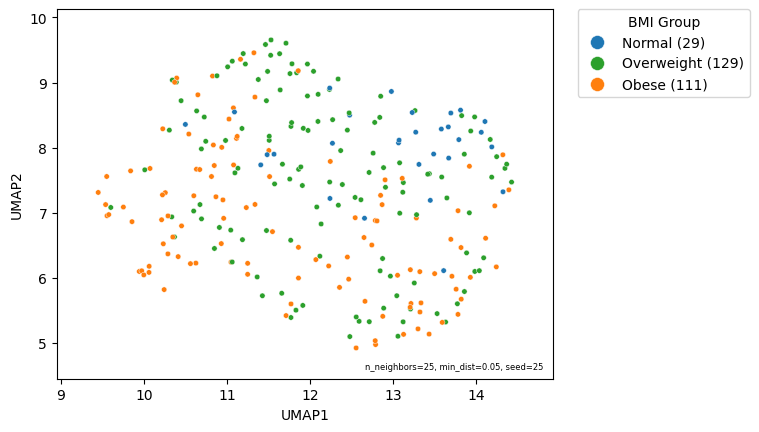

In [200]:
create_nice_embedding_plot(trainval_embedding, 'BMI Group', df, is_umap=True)
plt.text(0.98, 0.02, desc_text, 
    verticalalignment='bottom', 
    horizontalalignment='right', 
    transform=plt.gca().transAxes,
    fontsize=6)

plt.savefig(os.path.join(chosen_umap_plots_dir, 'bmi-group_embedding.png'), dpi=300, bbox_inches='tight')

In [201]:
df2 = df.join(all_embeddings)
exercise_subset = df2[df2['SubStudy']=='Exercise'].copy()
# exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','2 min'])].copy()
exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','1 hour'])].copy()
# exercise_subset = exercise_subset[exercise_subset['Exercise'].isin(['Baseline','15 min'])].copy()
exercise_subset_normal = exercise_subset[exercise_subset['BMI Group']=='Normal']
exercise_subset_overweight = exercise_subset[exercise_subset['BMI Group']=='Overweight']
exercise_subset_obese = exercise_subset[exercise_subset['BMI Group']=='Obese']

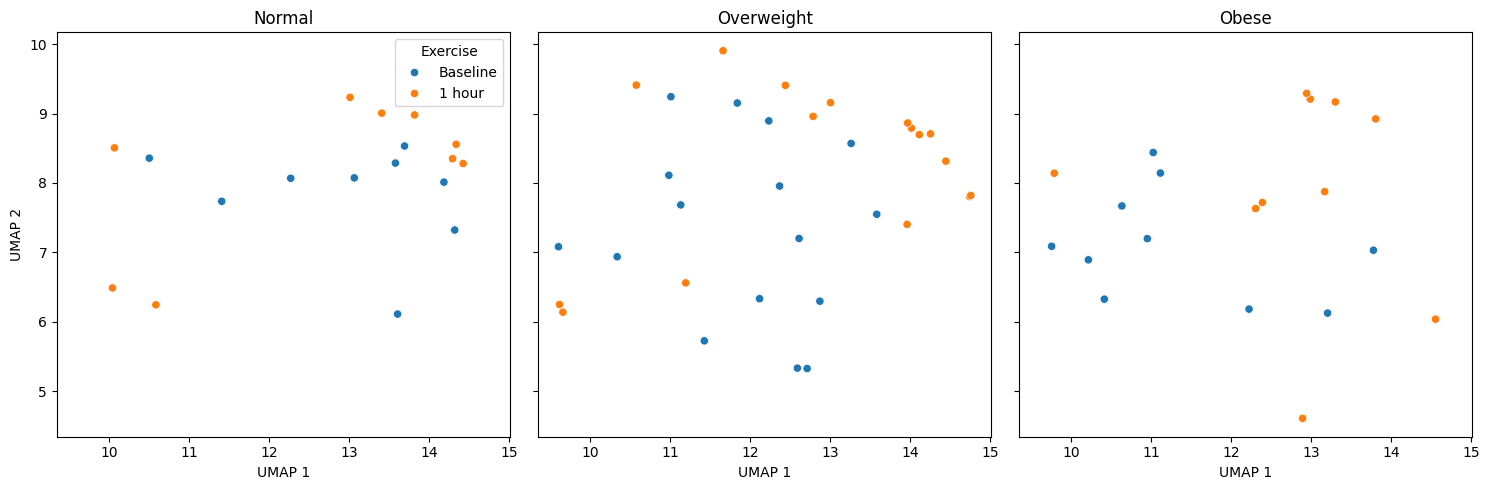

In [202]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Define the labels for the subplots
labels = ['Normal', 'Overweight', 'Obese']

# Iterate over the subplots and plot the UMAP scatter plot for each group
for i, ax in enumerate(axes):
    # Get the subset of the dataframe for the current group
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    
    # Get the UMAP embedding values for the subset
    umap_values = subset[['UMAP1', 'UMAP2']].values
    
    
    # Scatter plot with UMAP values as x and y coordinates, and event time as color
    # ax.scatter(umap_values[:, 0], umap_values[:, 1], c=event_time, cmap='viridis')
    sns.scatterplot(data=subset, x='UMAP1', y='UMAP2', hue='Exercise', palette='tab10', ax=ax)
    # remove the legend
    if i > 0:
        ax.get_legend().remove()


    
    # Set the title and axis labels for the subplot
    ax.set_title(labels[i])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

# Add a colorbar to the last subplot
# cbar = plt.colorbar(ax=axes[-1])
# cbar.set_label('Event Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join(chosen_umap_plots_dir, 'sorted-bmi_embedding.png'), dpi=300, bbox_inches='tight')

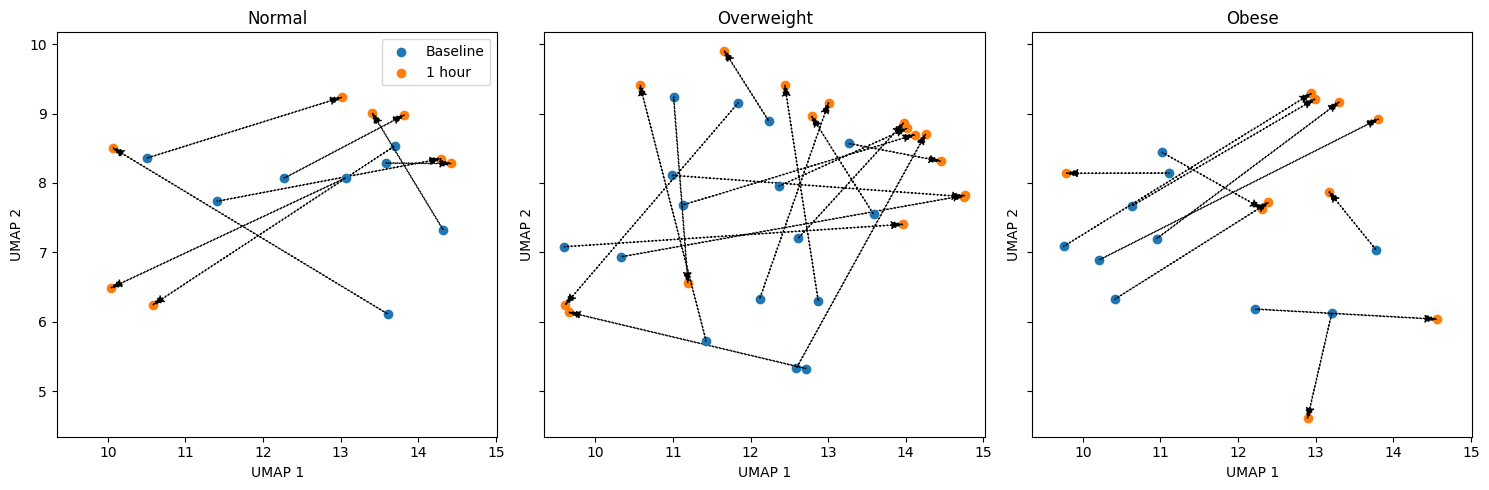

In [203]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Define the labels for the subplots
labels = ['Normal', 'Overweight', 'Obese']

# Iterate over the subplots and plot the UMAP scatter plot for each group
for i, ax in enumerate(axes):
    # Get the subset of the dataframe for the current group
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    subset = subset.drop_duplicates(subset=['subject ID', 'Event_Note1'])
    matched_subset = subset.pivot(index='subject ID', columns='Event_Note1', values=['UMAP1','UMAP2'])
    
    for idx, row in matched_subset.iterrows():
        # Get the coordinates for the 'Baseline' and '1 hour' points
        baseline_x = row[('UMAP1', 'Baseline')]
        baseline_y = row[('UMAP2', 'Baseline')]
        hour_x = row[('UMAP1', '1 hour')]
        hour_y = row[('UMAP2', '1 hour')]

        # Draw a scatter plot for the 'Baseline' point
        ax.scatter(baseline_x, baseline_y, color='C0', label='Baseline' if idx == matched_subset.index[0] else "")
        
        # Draw a scatter plot for the '1 hour' point
        ax.scatter(hour_x, hour_y, color='C1', label='1 hour' if idx == matched_subset.index[0] else "")
        
        # Draw an arrow from the 'Baseline' point to the '1 hour' point
        ax.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
                head_width=0.1,width=0.005,linestyle=':')

    # add a legend
    if i == 0:
        ax.legend()


    
    # Set the title and axis labels for the subplot
    ax.set_title(labels[i])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

# Add a colorbar to the last subplot
# cbar = plt.colorbar(ax=axes[-1])
# cbar.set_label('Event Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig(os.path.join(chosen_umap_plots_dir, 'arrow-bmi_embedding.png'), dpi=300, bbox_inches='tight')

Number of samples: 269


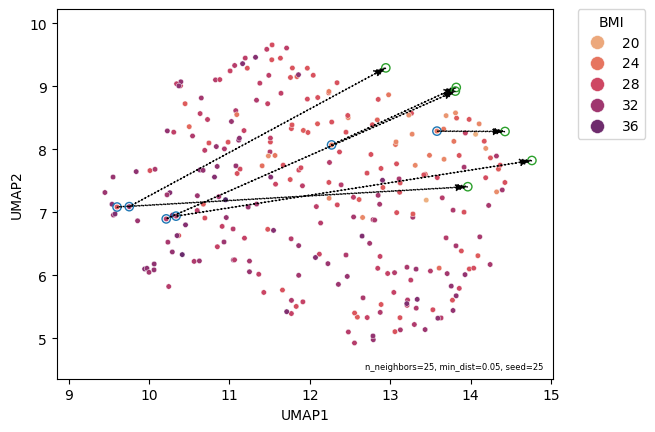

In [204]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, is_umap=True,margin_amount=0.12)
# add some text in the corner of the plot
# how to make this text smllar"
plt.text(0.98, 0.02, desc_text, 
    verticalalignment='bottom', 
    horizontalalignment='right', 
    transform=plt.gca().transAxes,
    fontsize=6)

for i in range(3):
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    subset = subset.drop_duplicates(subset=['subject ID', 'Event_Note1'])
    matched_subset = subset.pivot(index='subject ID', columns='Event_Note1', values=['UMAP1','UMAP2'])
    
    hour_x = matched_subset[('UMAP1', '1 hour')]
    hour_y = matched_subset[('UMAP2', '1 hour')]
    baseline_x = matched_subset[('UMAP1', 'Baseline')]
    baseline_y = matched_subset[('UMAP2', 'Baseline')]
    r_dist = np.sqrt((hour_x - baseline_x)**2 + (hour_y - baseline_y)**2)
    if i == 0:
        r_dist = r_dist.sort_values(ascending=True)
    else:
        r_dist = r_dist.sort_values(ascending=False)
    
    bmi_group =labels[i]
    for j in range(2):
        row = matched_subset.loc[r_dist.index[j]]
        baseline_x = row[('UMAP1', 'Baseline')]
        baseline_y = row[('UMAP2', 'Baseline')]
        hour_x = row[('UMAP1', '1 hour')]
        hour_y = row[('UMAP2', '1 hour')]

        # Draw a scatter plot for the 'Baseline' point
        plt.scatter(baseline_x, baseline_y, edgecolor='C0', facecolors='none',
            label=f'{bmi_group} Baseline' if idx == matched_subset.index[0] else "")
        
        # Draw a scatter plot for the '1 hour' point
        plt.scatter(hour_x, hour_y, edgecolor='C2', facecolors='none',
            label=f'{bmi_group} 1 hour' if idx == matched_subset.index[0] else "")
        
        # Draw an arrow from the 'Baseline' point to the '1 hour' point
        plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
                head_width=0.1,width=0.005,linestyle=':')

plt.savefig(os.path.join(chosen_umap_plots_dir, 'color_top_movement_embedding.png'), dpi=300, bbox_inches='tight')                

Number of samples: 269


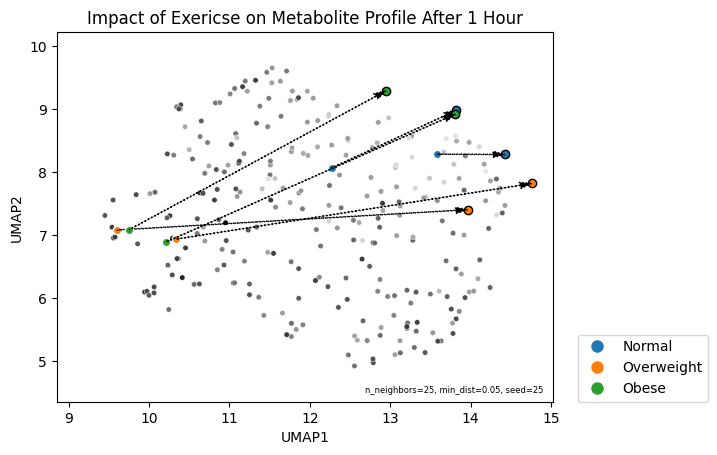

In [205]:
create_nice_embedding_plot(trainval_embedding, 'BMI', df, is_umap=True,palette='gray_r',margin_amount=0.12)
# remove the legend
# plt.gca().get_legend().remove()

# add some text in the corner of the plot
# how to make this text smllar"
plt.text(0.98, 0.02, desc_text, 
    verticalalignment='bottom', 
    horizontalalignment='right', 
    transform=plt.gca().transAxes,
    fontsize=6)

label_colors = ['C0','C1','C2']
for i in range(3):
    subset = exercise_subset[exercise_subset['BMI Group'] == labels[i]]
    subset = subset.drop_duplicates(subset=['subject ID', 'Event_Note1'])
    matched_subset = subset.pivot(index='subject ID', columns='Event_Note1', values=['UMAP1','UMAP2'])
    
    hour_x = matched_subset[('UMAP1', '1 hour')]
    hour_y = matched_subset[('UMAP2', '1 hour')]
    baseline_x = matched_subset[('UMAP1', 'Baseline')]
    baseline_y = matched_subset[('UMAP2', 'Baseline')]
    r_dist = np.sqrt((hour_x - baseline_x)**2 + (hour_y - baseline_y)**2)
    if i == 0:
        r_dist = r_dist.sort_values(ascending=True)
    else:
        r_dist = r_dist.sort_values(ascending=False)
    
    bmi_group =labels[i]
    for j in range(2):
        row = matched_subset.loc[r_dist.index[j]]
        baseline_x = row[('UMAP1', 'Baseline')]
        baseline_y = row[('UMAP2', 'Baseline')]
        hour_x = row[('UMAP1', '1 hour')]
        hour_y = row[('UMAP2', '1 hour')]

        # Draw a scatter plot for the 'Baseline' point
        plt.scatter(baseline_x, baseline_y, edgecolor='white', facecolors=label_colors[i],
            label=f'{bmi_group} Baseline' if idx == matched_subset.index[0] else "")
        
        # Draw a scatter plot for the '1 hour' point
        plt.scatter(hour_x, hour_y, edgecolor='black', facecolors=label_colors[i],
            label=f'{bmi_group} 1 hour' if idx == matched_subset.index[0] else "")
        
        # Draw an arrow from the 'Baseline' point to the '1 hour' point
        plt.arrow(baseline_x, baseline_y, hour_x - baseline_x, hour_y - baseline_y, color='black', length_includes_head=True, 
                head_width=0.1,width=0.005,linestyle=':')

    # place legend outside of the plot
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)     
# plt.savefig(os.path.join(chosen_umap_plots_dir, 'gray_top_movement_embedding.png'), dpi=300, bbox_inches='tight')  

# add a custom legend to the plot for the Obsese groups
# legend_text = ['Normal Baseline', 'Normal 1 hour', 'Overweight Baseline', 'Overweight 1 hour', 'Obese Baseline', 'Obese 1 hour']
# legend_colors = ['C0','C0','C1','C1','C2','C2']
# legend_markers = ['o','o','o','o','o','o']
legend_text = ['Normal', 'Overweight', 'Obese']
legend_colors = ['C0','C1','C2']
legend_markers = ['o','o','o']


legend_labels = []
for i in range(3):
    legend_labels.append(f'{labels[i]}')
    # for j in range(2):
    #     legend_labels.append(f'{labels[i]} {["Baseline","1 hour"][j]}')
plt.legend(handles=[plt.Line2D([0], [0], marker=legend_markers[i], color='w',
    markerfacecolor=legend_colors[i], markersize=10, label=legend_text[i]) for i in range(3)],
     loc='lower left',bbox_to_anchor=(1.05, 0), borderaxespad=0.)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Impact of Exericse on Metabolite Profile After 1 Hour')

plt.savefig(os.path.join(chosen_umap_plots_dir, 'gray_top_movement_embedding.png'), dpi=300, bbox_inches='tight')                

In [206]:
df

,subject ID,Study,Race,Age,BMI,SSPG,IR_IS_classification,CollectionDate,Event,Event_Note1,...,file name,mzml_file.1,timestamp,Ref,runtime_hour,batch_id,run_order,BMI Group,Exercise,Exercise Time
mzml_file,,,,,,,,,,,,,,,,,,,,,
Exercise_HILIC-pos_ZJXC41N-E11.mzML,ZJXC41N,HMP,B,49.69,28.24,75.0,IS,1495.0,Exercise,Baseline,...,Exercise_HILIC-pos_ZJXC41N-E11,Exercise_HILIC-pos_ZJXC41N-E11.mzML,2017-08-08 22:34:44,0,5690.201111,2,906,Overweight,Baseline,0.000000
Exercise_HILIC-pos_ZK4CK8Y-E11.mzML,ZK4CK8Y,HMP,C,50.02,26.94,40.0,IS,1425.0,Exercise,Baseline,...,Exercise_HILIC-pos_ZK4CK8Y-E11,Exercise_HILIC-pos_ZK4CK8Y-E11.mzML,2017-08-03 07:21:10,0,5554.975000,2,797,Overweight,Baseline,0.000000
Exercise_HILIC-pos_ZKFV71L-E11.mzML,ZKFV71L,HMP,B,66.08,32.54,65.0,IS,1222.0,Exercise,Baseline,...,Exercise_HILIC-pos_ZKFV71L-E11,Exercise_HILIC-pos_ZKFV71L-E11.mzML,2017-08-07 09:24:28,0,5653.030000,2,875,Obese,Baseline,0.000000
Exercise_HILIC-pos_ZL63I8R-E11.mzML,ZL63I8R,HMP,C,62.88,32.94,220.0,IR,1063.0,Exercise,Baseline,...,Exercise_HILIC-pos_ZL63I8R-E11,Exercise_HILIC-pos_ZL63I8R-E11.mzML,2017-08-04 14:30:48,0,5586.135556,2,827,Obese,Baseline,0.000000
Exercise_HILIC-pos_ZL9BTWF-E11.mzML,ZL9BTWF,HMP,C,64.56,26.69,99.0,IS,1090.0,Exercise,Baseline,...,Exercise_HILIC-pos_ZL9BTWF-E11,Exercise_HILIC-pos_ZL9BTWF-E11.mzML,2017-08-09 10:08:47,0,5701.768611,2,931,Overweight,Baseline,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exercise_HILIC-pos_ZYHHR4Z-E14.mzML,ZYHHR4Z,HMP,C,43.99,26.47,NaN,Unknown,1315.0,Exercise,30 min,...,Exercise_HILIC-pos_ZYHHR4Z-E14,Exercise_HILIC-pos_ZYHHR4Z-E14.mzML,2017-08-05 14:06:16,0,5609.726667,2,842,Overweight,30 min,4.954196
Exercise_HILIC-pos_ZYHHR4Z-E15.mzML,ZYHHR4Z,HMP,C,43.99,26.47,NaN,Unknown,1315.0,Exercise,1 hour,...,Exercise_HILIC-pos_ZYHHR4Z-E15,Exercise_HILIC-pos_ZYHHR4Z-E15.mzML,2017-08-10 11:04:46,0,5726.701667,2,944,Overweight,1 hour,5.930737
Exercise_HILIC-pos_ZYHHR4Z-E16.mzML,ZYHHR4Z,HMP,C,43.99,26.47,NaN,Unknown,1315.0,Exercise,2 hours,...,Exercise_HILIC-pos_ZYHHR4Z-E16,Exercise_HILIC-pos_ZYHHR4Z-E16.mzML,2017-07-29 14:02:24,0,5441.662222,2,684,Overweight,2 hours,6.918863


Number of samples: 269


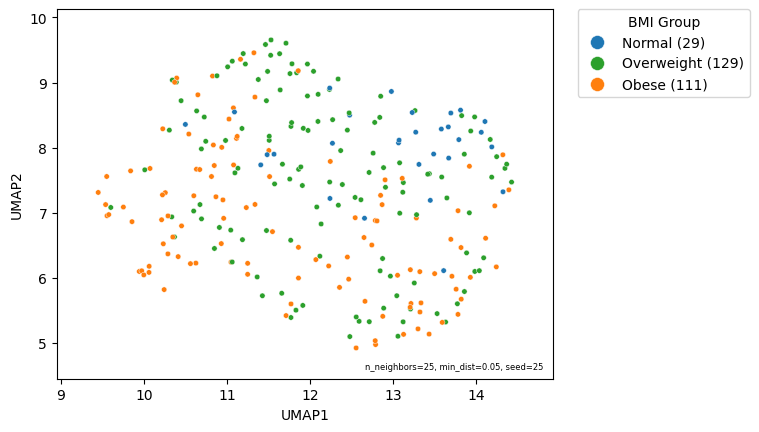

In [211]:
create_nice_embedding_plot(trainval_embedding, 'BMI Group', df, is_umap=True)
plt.text(0.98, 0.02, desc_text, 
    verticalalignment='bottom', 
    horizontalalignment='right', 
    transform=plt.gca().transAxes,
    fontsize=6)



In [212]:
df.columns

Index(['subject ID', 'Study', 'Race', 'Age', 'BMI', 'SSPG',
       'IR_IS_classification', 'CollectionDate', 'Event', 'Event_Note1',
       'Event_Note2', 'Event_Note3', 'SubStudy', 'file name', 'mzml_file.1',
       'timestamp', 'Ref', 'runtime_hour', 'batch_id', 'run_order',
       'BMI Group', 'Exercise', 'Exercise Time'],
      dtype='object')